In [1]:
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import path
import matplotlib.patches as patches
from skimage import draw
import scipy.ndimage as ndimage
import Utils
import georasters as gr
import cv2
from Utils import doubleMADsfromMedian
from skimage.transform import resize
import pickle

/home/dlsaavedra/anaconda3/envs/new/lib/python3.7/site-packages/pysal/__init__.py:65: VisibleDeprecationWarning: PySAL's API will be changed on 2018-12-31. The last release made with this API is version 1.14.4. A preview of the next API version is provided in the `pysal` 2.0 prelease candidate. The API changes and a guide on how to change imports is provided at https://migrating.pysal.org
  ), VisibleDeprecationWarning)


 # Load Image and Segmentation 

<Figure size 432x288 with 0 Axes>

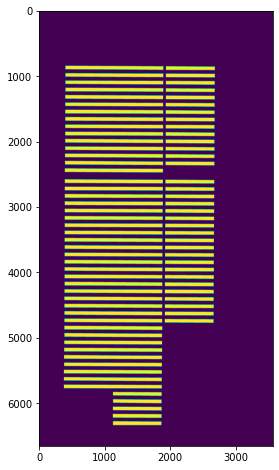

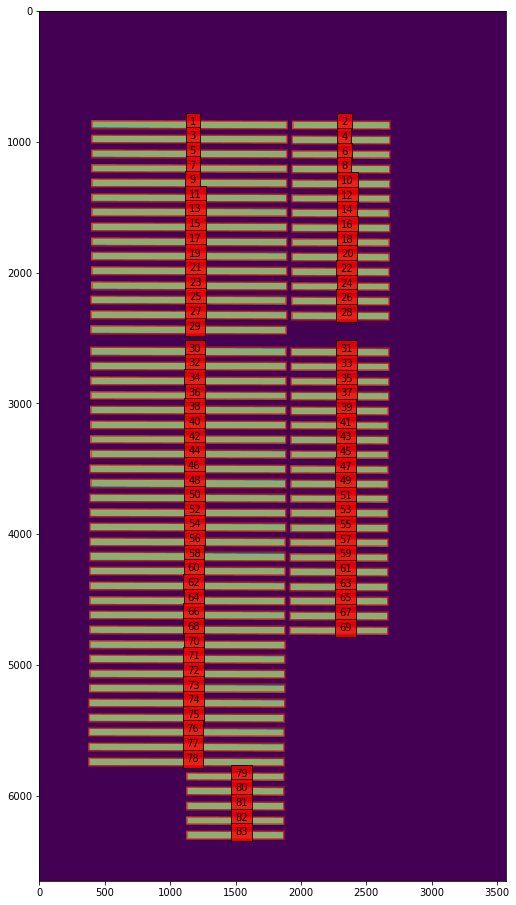

In [10]:
#path_C = "El_Aguila/result_C.tif"
path_RGB = "El_Aguila_2020/RGB.tif"
path_T = "El_Aguila_2020/Thermo.tif"
path_String = "El_Aguila_2020/Thermo_String_PV01.tif"
path_save_list = "El_Aguila_2020/List_strings_panels_PV01.txt"
path_save_list_print = "El_Aguila_2020/List_strings_panels_print_PV01.txt"

GR_String = gr.from_file(path_String)
GR_T = gr.from_file(path_T)
GR_RGB = gr.from_file(path_RGB)

plt.figure(0)
plt.figure(figsize=(8, 8))
plt.imshow(GR_String.raster.data > 0)
#plt.imshow((GR.raster[:3,:,:]).transpose((1, 2, 0))[::10,::10,:])


label_im, nb_labels = ndimage.label(GR_String.raster.data > 0)#, structure= np.ones((2,2))) ## Label each connect region

L_strings = {} # {name: '001', points:(top-left, top-right, bottom-right, bottom-left) (x,y), 'panels' : }

epsilon = 0


for i in range(1, nb_labels + 1):
    
    countours, hierarchy = cv2.findContours(np.uint8(label_im == i), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    x_max = np.max(countours[0][:, 0, 0]) + epsilon
    y_max = np.max(countours[0][:, 0, 1]) + epsilon
    x_min = np.min(countours[0][:, 0, 0]) - epsilon
    y_min = np.min(countours[0][:, 0, 1]) - epsilon
    
    List_P = np.array([(x_min, y_min), (x_max, y_min), (x_max, y_max), (x_min, y_max)])

    L_strings[str(i)] = {'id': i, 
                         'points' : List_P, 
                         'panels' : {}, 
                         'status': 'default', 
                         'T':0}

plt.figure(0)
plt.figure(figsize=(16, 16))
plt.imshow(GR_String.raster.data)

ax = plt.gca()

for Poly_key in L_strings.keys():
    
    Poly = L_strings[Poly_key]
    poly = patches.Polygon(Poly['points'],
                     linewidth=2,
                     edgecolor='red',
                     alpha=0.5,
                     fill = True)
    plt.text(np.mean([x[0]  for x in Poly['points']]), np.mean([y[1]  for y in Poly['points']]) , str(Poly['id']),  bbox=dict(facecolor='red', alpha=0.8))

    ax.add_patch(poly)
    

# Example of division to panel

<Figure size 432x288 with 0 Axes>

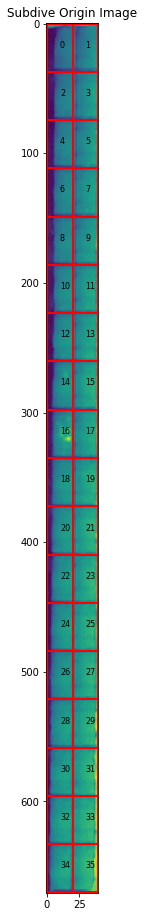

In [3]:
panel_size = (37 , 17) #weight, height size#
#panel_size = (20 , 35)
overlap = 0

string = L_strings['2']

Points = Utils.order_points_rect(string['points']).astype(np.int)

## If strings is vertical or horizontal
if (Points[2][0] - Points[0][0]) > (Points[2][1] - Points[0][1]):
    split_Weight, split_Height = np.int((Points[2][0] - Points[0][0]) / panel_size[0]) , np.int((Points[2][1] - Points[0][1]) / panel_size[1])
else:
    split_Weight, split_Height = np.int((Points[2][0] - Points[0][0]) / panel_size[1]) , np.int((Points[2][1] - Points[0][1]) / panel_size[0])


M, maxWidth, maxHeight = Utils.perspectiveTransform(Points)
sub_division = Utils.subdivision_rect([split_Weight, split_Height], maxWidth, maxHeight, overlap)
sub_division_origin = np.uint(cv2.perspectiveTransform(np.array(sub_division), np.linalg.inv(M)))


plt.figure(0)
plt.figure(figsize=(16, 16))
plt.imshow(GR_T.raster[0,Points[0][1] : Points[2][1], Points[0][0]: Points[2][0]])

plt.title('Subdive Origin Image')
ax = plt.gca()

for i,Poly in enumerate(sub_division_origin):
    poly = patches.Polygon(Poly - (Points[0][0], Points[0][1]),
                     linewidth=2,
                     edgecolor='red',
                     fill = False)
    plt.text(np.mean([x[0]  for x in Poly - (Points[0][0], Points[0][1])]), np.mean([y[1]  for y in Poly - (Points[0][0], Points[0][1])]) , 
             str(i),  bbox=dict(facecolor='red', alpha=0.0), fontsize=8)

    ax.add_patch(poly)


# Subdivision and save GPS coordinate panel

In [1]:

overlap = 0

for string_key in L_strings.keys():
    
    string = L_strings[string_key]
    string['panels'] = {}
    Points = Utils.order_points_rect( string['points']).astype(np.int)
    
    ## If strings is vertical or horizontal
    if (Points[2][0] - Points[0][0]) > (Points[2][1] - Points[0][1]):
        split_Weight, split_Height = np.int((Points[2][0] - Points[0][0]) / panel_size[0]) , np.int((Points[2][1] - Points[0][1]) / panel_size[1])
    else:
        split_Weight, split_Height = np.int((Points[2][0] - Points[0][0]) / panel_size[1]) , np.int((Points[2][1] - Points[0][1]) / panel_size[0])

    split_Weight = max(split_Weight, 1)
    split_Height = max(split_Height, 1)
    M, maxWidth, maxHeight = Utils.perspectiveTransform(Points)
    sub_division = Utils.subdivision_rect([split_Weight, split_Height], maxWidth, maxHeight, overlap)
    sub_division_origin = np.uint(cv2.perspectiveTransform(np.array(sub_division), np.linalg.inv(M)))
    
    for i,panels_coord in enumerate(sub_division_origin,1):
        string['panels'][str(i)] = {'id' : i,
                                    'points' : panels_coord,
                                    'status': 'default', 
                                    'T' : 0,
                                    'severidad': 'default'}


## Save List in coordinate latitud and longitude ###
geot = GR_String.geot
L_strings_coord = {}
           
for string_key in L_strings.keys():
    
    string = L_strings[string_key]
    points = string['points']
    string_coord = {'id': string['id'], 
                    'points': Utils.pixel2gps(points, geot), 
                    'panels': {}, 
                    'status': string['status'], 
                    'T' : string['T']}
    
    for panel_key in string['panels'].keys():
           
        panel = string['panels'][panel_key]
        points = panel['points']
        panel_coord = {'id': panel['id'],
                       'points': Utils.pixel2gps(points, geot), 
                       'status': panel['status'], 
                       'prob': 0.0, 
                       'T': 0,  
                       'severidad': 'default'}
        
        string_coord['panels'][panel_key] = panel_coord
        
    L_strings_coord[string_key] = string_coord





NameError: name 'L_strings' is not defined

<Figure size 432x288 with 0 Axes>

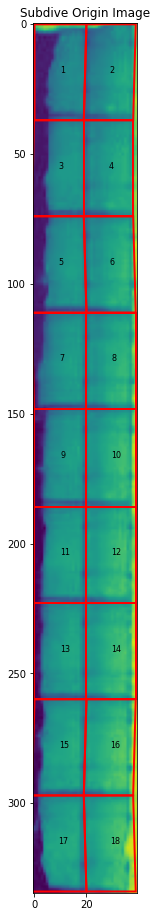

In [5]:
## Load List in coordinate latitud and longitude  to pixels ###
epsilon = 0
matrix_expand_bounds = [[-epsilon, -epsilon],[+epsilon, -epsilon], [+epsilon, +epsilon], [-epsilon, +epsilon]]

#geot = GR_RGB.geot
geot = GR_T.geot


string = L_strings_coord_load['1']
panels = string['panels']
Points = Utils.gps2pixel(string['points'], geot) + matrix_expand_bounds

plt.figure(0)
plt.figure(figsize=(16, 16))
plt.imshow(GR_T.raster[0,Points[0][1] : Points[2][1], Points[0][0]: Points[2][0]])
#plt.imshow((GR_RGB.raster[:3,:,:]).transpose((1, 2, 0))[Points[0][1] : Points[2][1], Points[0][0]: Points[2][0],:])

plt.title('Subdive Origin Image')
ax = plt.gca()

for Poly_key in panels.keys():
    
    Poly = panels[Poly_key]
    poly = patches.Polygon(Utils.gps2pixel(Poly['points'],geot) - (Points[0][0], Points[0][1]),
                     linewidth=2,
                     edgecolor='red',
                     fill = False)
    plt.text(np.mean([x[0]  for x in Utils.gps2pixel(Poly['points'],geot) - (Points[0][0], Points[0][1])]), np.mean([y[1]  for y in Utils.gps2pixel(Poly['points'],geot) - (Points[0][0], Points[0][1])]) , 
             str(Poly['id']),  bbox=dict(facecolor='red', alpha=0.0), fontsize=8)

    ax.add_patch(poly)


<Figure size 432x288 with 0 Axes>

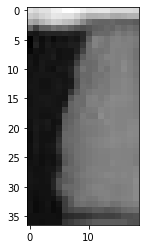

In [8]:
Points = Utils.gps2pixel(string['panels']['1']['points'], geot) + matrix_expand_bounds
plt.figure(0)
plt.figure(figsize=(4, 4))
plt.imshow(GR_T.raster[0,Points[0][1] : Points[2][1], Points[0][0]: Points[2][0]],cmap = 'gray')
#plt.imshow((GR_RGB.raster[:3,:,:]).transpose((1, 2, 0))[Points[0][1] : Points[2][1], Points[0][0]: Points[2][0],:])


In [9]:
L_strings

{'1': {'id': 1,
  'points': array([[1986, 5309],
         [2026, 5309],
         [2026, 5644],
         [1986, 5644]]),
  'panels': {'1': {'id': 1,
    'points': array([[1986, 5309],
           [2006, 5309],
           [2005, 5346],
           [1986, 5346]], dtype=uint64),
    'status': 'default',
    'T': 0},
   '2': {'id': 2,
    'points': array([[2006, 5309],
           [2025, 5309],
           [2024, 5346],
           [2005, 5346]], dtype=uint64),
    'status': 'default',
    'T': 0},
   '3': {'id': 3,
    'points': array([[1986, 5346],
           [2005, 5346],
           [2005, 5383],
           [1985, 5383]], dtype=uint64),
    'status': 'default',
    'T': 0},
   '4': {'id': 4,
    'points': array([[2005, 5346],
           [2024, 5346],
           [2024, 5383],
           [2005, 5383]], dtype=uint64),
    'status': 'default',
    'T': 0},
   '5': {'id': 5,
    'points': array([[1985, 5383],
           [2005, 5383],
           [2006, 5420],
           [1985, 5420]], dtype=uint64)

In [ ]:
""""
plt.figure(0)
plt.figure(figsize=(8, 8))
path_String = "El_Aguila_2020/Thermo_String.tif"
GR_String = gr.from_file(path_String)

A = GR_String
A.raster.data[:, :1900] = 0
A.raster.mask[:, :1900] = True
A.raster.data[:5000, :] = 0
A.raster.mask[:5000, :] = True

A.to_tiff("El_Aguila_2020/Thermo_String_PV03")
plt.imshow(A.raster.data)
"""